![Header](https://raw.githubusercontent.com/johnmrudolph/jupyter_blog/master/headers/declining_wa_consumption.png)

<h2 style="color:#003f5b">Is Washington State Residential Per Capita Electricity Consumption on the Decline?</h2>

Energy efficiency is a hot topic in the electricity industry. If you read Integrated Resource Plans (IRPs) you will see that energy efficiency is often one of the cheapest resources that can be used to meet new incremental load growth which is why many utilities have invested so heavily into their efficiency programs. Utilities have had sponsored efficiency programs for decades but more recently changes in appliance standards, building codes and technlogical innovation have created a paradigm shift where load growth has decoupled from economic growth.

The concept of declining electricity sales or flattening load isn't news to those in the electricity industry but the trend has gained more mainstream attention in recent years. For a good primer check ou this EIA article https://www.eia.gov/todayinenergy/detail.php?id=32212 or this Berkley blog: http://blogs.berkeley.edu/2017/05/08/evidence-of-a-decline-in-electricity-use-by-u-s-households/.

Taking some inspiration from the EIA and Berkley pieces, I thought it would be interesting to examine Washington State per capita electricity sales to see how strongly this declining residential energy intensity trend presented itself. To make things a little more interesting I also decided to play around with 3 different univariate detrending methods to try to account for the year-to-year weather variation, which is important since the Northwest experienced unusually warm weather from 2014-2016 and unusually cold weather in 2017:

1. A LOESS smoother: http://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
2. Statsmodels TSA seasonal decomposition: http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
3. Facebook's forecasting package Prophet: https://research.fb.com/prophet-forecasting-at-scale/

Admittedly this was just a poor excuse to play around with Facebook's new forecasting model.

<h2 style="color:#003f5b">Importing Packages</h2>

We'll import a handful of packages here. I've got a local script to pull data from the EIA API which you can find on my github: https://github.com/johnmrudolph/jupyter_blog/blob/master/scripts/eiapi.py. Most of the other packages are pretty vanilla but I'll call attention to fbprophet since this is Facebook's forecasting package and it might look unfamiliar.

In [2]:
# import local script
import sys
sys.path.insert(0, '/home/john/jupyter_blog/jupyter_blog/scripts')

import numpy as np
import pandas as pd
import statsmodels.api as sm
import eiapi as epi
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from fbprophet import Prophet
%matplotlib inline
plt.style.use('bmh')

<h2 style="color:#003f5b">Pulling Washington Residential Consumption and Population Data</h2>

Here we'll make a call to the EIA api. We're requesting 2 series:
1. Washington State Residential Electricity Sales: ELEC.SALES.WA-RES.M
2. Washington State Annual Population: SEDS.TPOPP.WA.A

For more detail on how the API call to EIA work see this quick article I wrote up: 
https://github.com/johnmrudolph/jupyter_blog/blob/master/working_with_apis.ipynb.

In [3]:
# can be obtained from EIA here: http://www.eia.gov/opendata/register.php
api_key = '5F4109570C68FDE20F42C25F5152D879'
# start and end dates for beginning and end of time series
start = '2001-01-01 01:00:00'
end = '2017-12-31 23:00:00'
# must specify that frequency is annual'A' for datetime conversion
freq = 'A'

# full list of available series is here: http://www.eia.gov/opendata/qb.php?category=2122628
keys = ['ELEC.SALES.WA-RES.M', 'SEDS.TPOPP.WA.A']

# create dict of GetSeriesRange objects from series list
series_dict = {key: epi.GetSeries(api_key=api_key, series_id=key, 
                                    start=start, end=end, freq=freq) for key in keys}

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): api.eia.gov
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): api.eia.gov


<h2 style="color:#003f5b">Printing Out Some Info About The Raw Data</h2>

The two series that we pulled are loaded into a dictionary with a number of different keys which include the data and some descriptive information. I'm going to print out the full name of the series and the type of units.

In [4]:
for key in series_dict:
    print('Series Name: {} \n Units: {} \n Key {}'.format(series_dict[key].data.series[0]['name'], 
                             series_dict[key].data.series[0]['units'], key))

Series Name: Resident population including Armed Forces, Washington 
 Units: Thousand 
 Key SEDS.TPOPP.WA.A
Series Name: Retail sales of electricity : Washington : residential : monthly 
 Units: million kilowatthours 
 Key ELEC.SALES.WA-RES.M


So the full names of the 2 series are 1. Residential population including Armed Forces and 2. Retail sales of electricity, Washington, residential, monthly. The data type of the first series (units) is population in thousands and the second is electricity sales in million kWh.

<h2 style="color:#003f5b">Visually Inspecting Our Datasets</h2>

Before doing any kind of modeling I always visually inspect the data so let's graph the Washington Population and Electricity Sale data.

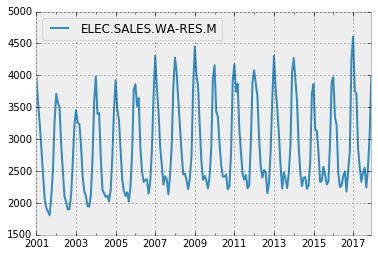

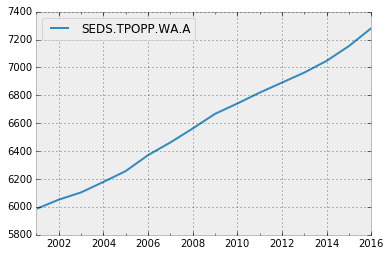

In [5]:
# create new data frames
wa_sales = series_dict['ELEC.SALES.WA-RES.M'].data.df.sort_index()
wa_pop = series_dict['SEDS.TPOPP.WA.A'].data.df.sort_index()

# convert index to datetime
wa_sales.index = pd.to_datetime(wa_sales.index)
wa_pop.index = pd.to_datetime(wa_pop.index)

# plot total washington residential electricity sales and population
wa_sales.plot()
wa_pop.plot()

<h2 style="color:#003f5b">Adding a Placeholder Population Estimate for 2017</h2>

The first plot shows the monthly electricity sales data which, not surprisingly, is highly seasonal. Washington is one of the few areas in the US that is winter peaking due to its high saturations of electric space heating and cold(ish) winter weather. The unusually warm period in 2015 and cold period in 2017 also stick out and highlight the the important role that weather plays in this analysis. 

Washington population is less interesting than the consumption data. It looks like a lumpy linear trend, though there appears to be an uptick from 2014-2016...BUT no population estimate for 2017 which doesn't jive with the electricity sales data. I'm going to do a quick workaround and manually append a 2017 Washington State Population estimate since it's not available yet through SEDS. Based on the most recently published data https://www.census.gov/quickfacts/WA it look like Washington State population growth was ~1.62% so we'll go with that growth rate for 2017.

In [6]:
# Estimate 2017 Washington Population
pop_2017 = wa_pop.loc['2016'].values*1.0162
# Create a dataframe for 2017 data and append to original set
pop_2017_df = pd.DataFrame(pop_2017, index=pd.to_datetime(['2017-01-01']), columns=[list(wa_pop)[0]])
wa_pop = wa_pop.append(pop_2017_df)
# Visually inspect to make sure data was added
print(wa_pop)

            SEDS.TPOPP.WA.A
2001-01-01        5986.0000
2002-01-01        6052.0000
2003-01-01        6104.0000
2004-01-01        6179.0000
2005-01-01        6257.0000
2006-01-01        6371.0000
2007-01-01        6462.0000
2008-01-01        6562.0000
2009-01-01        6667.0000
2010-01-01        6741.0000
2011-01-01        6819.0000
2012-01-01        6891.0000
2013-01-01        6963.0000
2014-01-01        7047.0000
2015-01-01        7153.0000
2016-01-01        7281.0000
2017-01-01        7398.9522


<h2 style="color:#003f5b">Plot Per Capita Washington Electricity Sales and a Create LOESS Smoother</h2>

A few things need to happen in this step. The electricity sales and population data need to be merged, but we need to aggregate the sales data from monthly to annual before the merge can happen. Once the datasets are merged we can calculate per capita consumption, plot and run a LOESS smoother through the data points.

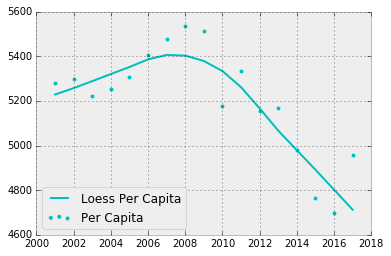

In [7]:
# Group sales data to annual, merge with population series and create per capita
wa_sales_annual = wa_sales.groupby(pd.Grouper(freq='A'))['ELEC.SALES.WA-RES.M'].agg(['sum'])
wa_sales_annual['year'] = wa_sales_annual.index.to_period('A')
wa_pop['year'] = wa_pop.index.to_period('A')
wa_merged = pd.merge(wa_sales_annual, wa_pop, on='year')
wa_merged['year'] = wa_merged['year'].astype(str).astype(int)
# Create the per capita variable here and we'll convert from MWh to kWh
wa_merged['per_capita'] = wa_merged['sum']*1000/wa_merged['SEDS.TPOPP.WA.A']

# Create Loess of Per Capita
wa_merged['per_capita_loess'] = sm.nonparametric.lowess(
    wa_merged['per_capita'], wa_merged['year'], return_sorted=False)

# Graph Smoothed Electricity Sales Per Capita
plt.scatter(wa_merged['year'], wa_merged['per_capita'], c='c', label='Per Capita')
plt.plot(wa_merged['year'], wa_merged['per_capita_loess'], c='c', label='Loess Per Capita')
plt.legend(loc=3)
plt.show()

<h2 style="color:#003f5b">Interpreting the Per Capita Consumption Graph</h2>

The LOESS smoother above shows a clear declining trend which started after 2008. At its peak in 2008 Washington per capita consumption was ~5,400 kWh but in the last decade it has fallen by almost 13% to ~4,700 kWh. This is a pretty steep drop and included in this trend is a very warm 3 year period (2014-2016) that could be having an amplifying effect. Let's see how much these results change by trying to account for some of this weather variability using some other modeling approached that handle the seasonality directly.

<h2 style="color:#003f5b">Deseasonalize Electricity Sales Data using a Time Series Seasonal Decomposition</h2>

We'll start by using simple univariate time series decomposition. This will break our series into 3 additive components: 1. Long-term Trend (Trend) 2. 12 Month Seasonal (Seasonal) and 3. Short-term Noise (Residual). Keep in mind that the seasonal portion is deterministic so it will estimate the average seasonal effect on electricity consumption over the entire series but will not account for any year to year weather variation. So we're also hoping that the residual component will pick up any weather related impacts that our seasonal component misses and that our trend component will be a nice smooth baseline consumption estimate.

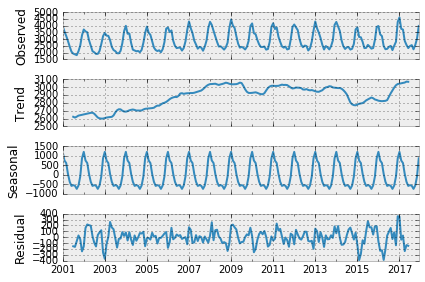

In [8]:
# Run seasonal decomposition and plot
wa_sales_decompose = sm.tsa.seasonal_decompose(wa_sales, freq=12, model='additive')
decmpose_plot = wa_sales_decompose.plot()

<h2 style="color:#003f5b">Interpreting the Decomposition Plots</h2>

We get 4 subplots when we call the plot method on the tsa.seasonal_decompose object, one for the observation series and the remaining three for each of decomposition components. We're hoping that the seasonal and residual series will pick up the weather related impacts and it appears this is at least partially the case. However, the trend plot doesn't look great because there are still irregular dips and jumps in the warm and cold periods which indicates that we still have some pretty significant lingering weather effects.

<h2 style="color:#003f5b">Create TSA Seasonally Adjusted Per Capita Consumption</h2>

Let's pull the trend component from the seasonal decomposition object, aggreate it from monthly to annual values and then link with our population data. We'll create the seasonally adjusted per capita variable by dividing the annual sum of the trend by the annual population. We should end up with values that are pretty similar to what we saw in the LOESS plot.

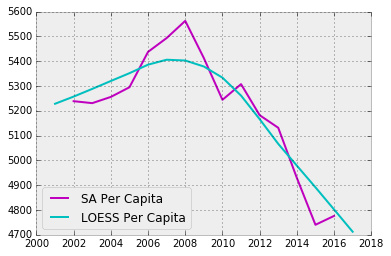

In [13]:
# Create a filtered series : trend 
wa_sales_tsa = wa_sales_decompose.trend
# Group deaseasonalized sales trend by year
wa_sales_tsa_annual = wa_sales_tsa.groupby(
    pd.Grouper(freq='A'))['ELEC.SALES.WA-RES.M'].agg(['sum','count'])
# Drop years where there isn't 12 months of filtered data
wa_sales_tsa_annual = wa_sales_tsa_annual[wa_sales_tsa_annual['count']==12]
wa_sales_tsa_annual.drop('count', axis=1, inplace=True)

# create annual key and merge sales and population dfs
wa_sales_tsa_annual['year'] = wa_sales_tsa_annual.index.to_period('A')
wa_tsa_merged = pd.merge(wa_sales_tsa_annual, wa_pop, on='year')
# coerce year datetime to int
wa_tsa_merged['year'] = wa_tsa_merged['year'].astype(str).astype(int)
# create per_capita sales variable
wa_tsa_merged['per_capita_tsa'] = wa_tsa_merged['sum']*1000 / wa_tsa_merged['SEDS.TPOPP.WA.A']

# plot seasonally adjusted trend vs LOESS
plt.plot(wa_tsa_merged['year'], wa_tsa_merged['per_capita_tsa'], c='m', label='SA Per Capita')
plt.plot(wa_merged['year'], wa_merged['per_capita_loess'], c='c', label='LOESS Per Capita')
plt.legend(loc=3)
plt.show()

<h2 style="color:#003f5b">LOESS or TSA Seasonally Adjusted Trend?</h2>

We've overlayed the Seasonally Adjusted (SA Per Capita) and LOESS trend onto the same plot. Both are showing the same general trend, that per capita consumption is declining, but the SA Per Capita is a little jumpier than I what I would reasonably expect if our narative is about energy efficiency. So I prefer the LOESS smoother at this point but let's see how Facebook's Prophet model does.

<h2 style="color:#003f5b">Creating the Prophet Model</h2>

I had to spend a little bit of time reading the Prophet model docs but all things considered it's a pretty intuitive framework. The Prophet model is conceptualy similar to the seasonal decomposition model in that it breaks the observed series into additive trend and seasonal components but Prophet's use of piecewise linear functions for the trend and Fourier decomposition for the season means that what is going on under the hood is different. Let's put the Prophet model to work. I followed facebook's example for monthly data which can be found here: https://facebook.github.io/prophet/docs/non-daily_data.html.

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


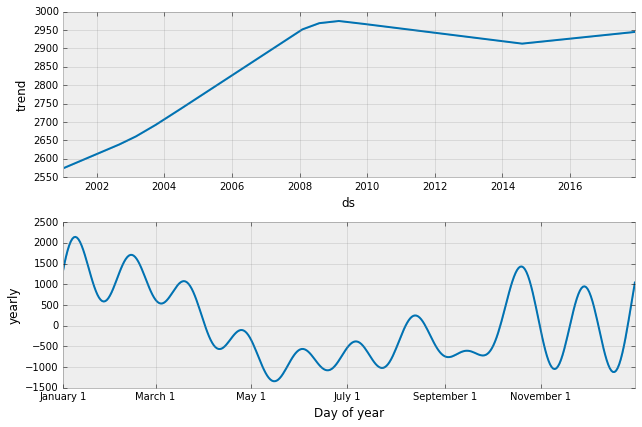

In [14]:
# Prophet requires independent (y) and Datetime (ds) inputs vars in dataframe
df = pd.DataFrame(columns=['y','ds'])
df['ds'] = wa_sales.index
df['y'] = wa_sales['ELEC.SALES.WA-RES.M'].values

# fit the prophet model
m = Prophet().fit(df)
# specifying a mothly frequency for the input series
future = m.make_future_dataframe(periods=0, freq='M')
fcst = m.predict(future)
fcst.index = fcst['ds'].values
comp_plot = m.plot_components(fcst)

<h2 style="color:#003f5b">Interpreting the Prophet Additive Components</h2>

The Prophet model's plot_components method shows the trend and monthly seasonality, similar to the seasonal decomposition plots. One difference is that the seasonal component is not shown over the entire time series, instead it is just shown for a representative year. The seasonal component shows that the winter months have higher consumption relative to the shoulder and summer seasons. 

We can also see the impacts of the piecewise linear function in the trend component, it appears to be picking up change points around 2009 and 2015 but it is much smoother than what we saw in the seasonal decomposition. The impacts of the fourier decomposition can also be seen pretty clearly in the seasonal component, notice how it looks like a combination of different SIN/COS curves with varying frequencies and amplitudes.

<h2 style="color:#003f5b">Create Prophet Trend Adjusted Per Capita Consumption</h2>

We have to extract the Prophet trend component from the model object, aggregate and merge the trend series with the washington population data. Finally we'll plot all of our trend components and see which gives us the most reasonable result.

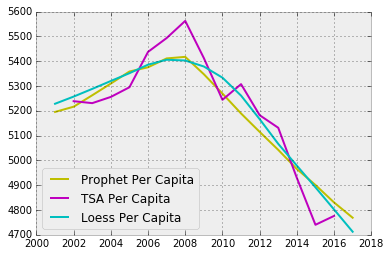

In [16]:
# group deaseasonalized sales trend by year
wa_sales_proph = fcst.groupby(pd.Grouper(freq='A'))['trend'].agg(['sum'])
# create annual key and merge sales and population dfs
wa_sales_proph['year'] = wa_sales_proph.index.to_period('A')
wa_proph_merged = pd.merge(wa_sales_proph, wa_pop, on='year')
# coerce year datetime to int
wa_proph_merged['year'] = wa_proph_merged['year'].astype(str).astype(int)
# create per_capita sales variable
wa_proph_merged['per_capita_proph'] = (wa_proph_merged['sum']*1000 / 
                                   wa_proph_merged['SEDS.TPOPP.WA.A'])

# plot Prophet Per Capita vs SA Per Capita and LOESS Per Capita
plt.plot(wa_proph_merged['year'], wa_proph_merged['per_capita_proph'], c='y', label='Prophet Per Capita')
plt.plot(wa_tsa_merged['year'], wa_tsa_merged['per_capita_tsa'], c='m', label='TSA Per Capita')
plt.plot(wa_merged['year'], wa_merged['per_capita_loess'], c='c', label='Loess Per Capita')
plt.legend(loc=3)
plt.show()

<h2 style="color:#003f5b">Wrapping Everything Up</h2>

In the graph above we have our 3 per capita consumption trends plotted. All 3 trending models show a declining consumption trend that starts after 2008 and that rate of change is pretty similar if we go with either the LOESS or Prophet trends. If I had to choose one I would still probably go with the LOESS trend because it is a more common modelling approach and would require less additional explanation if I was to actually use the trend data in a more official type of analysis. If we wanted to make this exercise more robust we would need to incorporate a monthly temperature component and model it using some kind of non-linear function like a spline but that's a large body of additional work, worth of its own write up.